In [28]:
import tensorflow.compat.v1 as tf
import pandas as pd
import seaborn as sns
import scipy.io
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import hdf5storage

In [29]:
def fnn(x, input_size, output_size, keep_prob, stddev=0.01, constant=0.0001, dropout=True, end=False):
    fc_w = tf.Variable(tf.truncated_normal([input_size,output_size], stddev=stddev,seed=np.random.seed(2018)))
    fc_b = tf.Variable(tf.constant(constant,shape=[output_size]), dtype=tf.float32)
    fc_h = tf.nn.relu(tf.matmul(x,fc_w)+fc_b) if not end else tf.matmul(x,fc_w)+fc_b
    return tf.nn.dropout(fc_h, keep_prob,seed=np.random.seed(2018)) if dropout else fc_h

In [30]:
def fcn(x, input_size, output_size, nlayers, nparameters, keep_prob):
    if nlayers == 1:
        h1 = fnn(x, input_size, output_size, keep_prob, end=True)
    elif nlayers == 2:
        h1 = fnn(fnn(x, input_size, nparameters, keep_prob, end=False), nparameters, output_size, keep_prob, end=True)
    elif nlayers >= 3:
        h0 = fnn(x, input_size, nparameters, keep_prob, end=False)
        for j in range(0,nlayers-2):
            if j == 0:
                h1 = fnn(h0, nparameters, nparameters, keep_prob, end=False)
            else:
                h1 = fnn(h1, nparameters, nparameters, keep_prob, end=False)
        h1 = fnn(h1, nparameters, output_size, keep_prob, end=True)
    else:
        print("# of layers can't be smaller than 0")
    return h1

In [31]:
def rfc(train_data, train_label, test_data, test_label):
    rf = RandomForestClassifier(n_estimators=150,
                                    criterion='gini',
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    max_leaf_nodes=None,
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=10,
                                    random_state=123,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None)
    rf.fit(train_data, train_label.ravel())
    result = rf.predict_proba(test_data)
    acc = 0.0
    for i in range(np.shape(test_data)[0]):
        r = np.argmax(result[i])
        if r == test_label[i]:
            acc += 1
    acc /= np.shape(test_data)[0]
    acc *= 100
    return acc, result

In [32]:
def dnn(train_data, train_label, test_data, test_label):
    g = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    batch_size = 10
    input_size = np.shape(train_data)[1]
    output_size = 31

    with g.as_default():
        p_x = tf.placeholder(tf.float32, [batch_size, 1, input_size, 1])
        p_y = tf.placeholder(tf.float32, [batch_size, output_size])
        keep_prob = tf.placeholder(tf.float32)
        h10_flat = tf.reshape(p_x, [batch_size,-1])
        h1 = fnn(h10_flat, input_size, 2048, keep_prob, end=False)
        h2 = fnn(h1, 2048, 2048, keep_prob, end=False)
        h3 = fnn(h2, 2048, 31, keep_prob, end=True)
        h4 = tf.reshape(h3, [batch_size, 31])
        h_c = tf.nn.softmax(h4)
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=p_y, logits=h4))
        optim = tf.train.AdamOptimizer(1e-5)
        trainer = optim.minimize(loss)
    
    accuracy = 0.0
    result = np.zeros([np.shape(test_data)[0], 31])
    with tf.Session(graph=g, config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(0,120):
            loss_tot = 0.0
            for i in range(0,int(np.ceil(np.shape(train_data)[0]/batch_size))):
                a = np.random.randint(0,np.shape(train_data)[0],size=batch_size)
                x = train_data[a].reshape([batch_size, 1, input_size, 1])#[4,1,18181,1]
                y = np.zeros([batch_size, output_size])
                index = train_label[a]
                for u in range(0,batch_size):
                    y[u,index[u]] = 1
                _ , loss_val = sess.run([trainer, loss], feed_dict={p_x:x, p_y:y, keep_prob:0.6})
                loss_tot += loss_val
            print("%d epoch Loss: %f" % (e,(loss_tot)/np.shape(train_data)[0]))
        temp = 0
        for i in range(0,int(np.floor(np.shape(test_data)[0]/batch_size))):
            x = test_data[i*batch_size:(i+1)*batch_size].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0, batch_size):
                t = np.squeeze(out[j])
                result[temp] = t
                temp+=1
        remain = int(np.shape(test_data)[0]-np.floor(np.shape(test_data)[0]/batch_size)*batch_size)
        if remain > 0:
            x = test_data[-batch_size-1:-1].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0,int(remain)):
                t = np.squeeze(out[j+(batch_size-remain)])
                result[temp] = t
                temp+=1
        for i in range(0,np.shape(test_data)[0]):
            ind = np.argmax(np.squeeze(result[i]))
            if ind == test_label[i]:
                accuracy += 1
        accuracy /= np.shape(test_data)[0]*0.01
        sess.close()
    return accuracy, result

In [33]:
dataID = hdf5storage.loadmat('data.mat')
data = np.array(dataID['data'], dtype=np.float32)
gt1 = scipy.io.loadmat('label.mat')
label = np.array(gt1['label'], dtype=np.int32)

In [34]:
Outer_loop = 10
Inner_loop = 10

In [46]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        #lasso = Lasso()
        lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        #coef = np.squeeze(np.sum(np.square(np.array(lasso.coef_)), axis=0))
        coefidx = np.argsort(coef)
#         for inner_fold in range(0,Inner_loop):
#             val_test_ind = kf[inner_fold]
#             if inner_fold == Inner_loop-1:
#                 val_test_ind = np.array(np.concatenate((val_test_ind,np.array(range(int(np.shape(train_data)[0]/Outer_loop)*Outer_loop,np.shape(train_data)[0]),dtype=np.int32)), axis=0),dtype=np.int32)
            
#             val_train_ind = np.setdiff1d(np.array(range(0,np.shape(train_data)[0]),dtype=np.int32), val_test_ind)
#             val_train = train_data[val_train_ind]
#             val_test = train_data[val_test_ind]
#             val_train_label = train_label[val_train_ind]
#             val_test_label = train_label[val_test_ind]
#             temp = 0
#             for item in box:
#                 idx = coefidx[-item:]
#                 vtrain = val_train[:,idx]
#                 vtest = val_test[:,idx]
#                 nn_acc, result_nn = dnn(vtrain, val_train_label, vtest, val_test_label)
#                 rf_acc, result_rf = rfc(vtrain, val_train_label, vtest, val_test_label)
#                 en_acc = 0.0
#                 for i in range(0,np.shape(vtest)[0]):
#                     r = np.argmax(result_nn[i]+result_rf[i])
#                     if r == val_test_label[i]:
#                         en_acc += 1
#                 en_acc /= np.shape(vtest)[0]*0.01
#                 tot_acc[inner_fold,temp] = en_acc
#                 print("Inner_fold # of features: %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (item, nn_acc, rf_acc, en_acc))
#                 temp += 1
        
        u = np.sum(tot_acc,0)
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        rf_acc, result_rf = rfc(tr_data, train_label, te_data, test_label)
        en_acc = 0.0
        for i in range(0,np.shape(te_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(te_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.310719
1 epoch Loss: 3.057256
2 epoch Loss: 2.842020
3 epoch Loss: 2.679981
4 epoch Loss: 2.518098
5 epoch Loss: 2.460461
6 epoch Loss: 2.322171
7 epoch Loss: 2.276983
8 epoch Loss: 2.190795
9 epoch Loss: 2.159150
10 epoch Loss: 2.060299
11 epoch Loss: 2.058204
12 epoch Loss: 1.976052
13 epoch Loss: 1.913965
14 epoch Loss: 1.945198
15 epoch Loss: 1.869561
16 epoch Loss: 1.817971
17 epoch Loss: 1.792062
18 epoch Loss: 1.741372
19 epoch Loss: 1.715327
20 epoch Loss: 1.644492
21 epoch Loss: 1.659347
22 epoch Loss: 1.634921
23 epoch Loss: 1.588886
24 epoch Loss: 1.562715
25 epoch Loss: 1.513573
26 epoch Loss: 1.511111
27 epoch Loss: 1.493179
28 epoch Loss: 1.429190
29 epoch Loss: 1.448614
30 epoch Loss: 1.452646
31 epoch Loss: 1.440261
32 epoch Loss: 1.381558
33 epoch Loss: 1.366764
34 epoch Loss: 1.337785
35 epoch Loss: 1.370940
36 epoch Loss: 1.320124
37 epoch Loss: 1.287493
38 epoch Loss: 1.285838
39 epoch Loss: 1.245378
40 epoch Loss: 1.262948
41 epoch Loss: 1.283731
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.299424
1 epoch Loss: 3.062167
2 epoch Loss: 2.857814
3 epoch Loss: 2.650655
4 epoch Loss: 2.540277
5 epoch Loss: 2.444268
6 epoch Loss: 2.340232
7 epoch Loss: 2.267813
8 epoch Loss: 2.188918
9 epoch Loss: 2.155684
10 epoch Loss: 2.089480
11 epoch Loss: 2.062339
12 epoch Loss: 1.999219
13 epoch Loss: 1.939038
14 epoch Loss: 1.901223
15 epoch Loss: 1.860395
16 epoch Loss: 1.841956
17 epoch Loss: 1.780767
18 epoch Loss: 1.705276
19 epoch Loss: 1.711139
20 epoch Loss: 1.688436
21 epoch Loss: 1.646381
22 epoch Loss: 1.650312
23 epoch Loss: 1.571922
24 epoch Loss: 1.568630
25 epoch Loss: 1.517843
26 epoch Loss: 1.508607
27 epoch Loss: 1.508571
28 epoch Loss: 1.467395
29 epoch Loss: 1.452396
30 epoch Loss: 1.428513
31 epoch Loss: 1.398368
32 epoch Loss: 1.412186
33 epoch Loss: 1.383392
34 epoch Loss: 1.355056
35 epoch Loss: 1.364988
36 epoch Loss: 1.352904
37 epoch Loss: 1.358970
38 epoch Loss: 1.288204
39 epoch Loss: 1.300534
40 epoch Loss: 1.305390
41 epoch Loss: 1.290972
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.305181
1 epoch Loss: 3.081078
2 epoch Loss: 2.849780
3 epoch Loss: 2.662886
4 epoch Loss: 2.540391
5 epoch Loss: 2.439088
6 epoch Loss: 2.358856
7 epoch Loss: 2.268872
8 epoch Loss: 2.217098
9 epoch Loss: 2.169975
10 epoch Loss: 2.081108
11 epoch Loss: 2.049602
12 epoch Loss: 1.992225
13 epoch Loss: 1.904408
14 epoch Loss: 1.933161
15 epoch Loss: 1.859438
16 epoch Loss: 1.831039
17 epoch Loss: 1.763823
18 epoch Loss: 1.727908
19 epoch Loss: 1.711636
20 epoch Loss: 1.672765
21 epoch Loss: 1.633638
22 epoch Loss: 1.654721
23 epoch Loss: 1.592889
24 epoch Loss: 1.596395
25 epoch Loss: 1.524454
26 epoch Loss: 1.517944
27 epoch Loss: 1.512854
28 epoch Loss: 1.453163
29 epoch Loss: 1.444536
30 epoch Loss: 1.436003
31 epoch Loss: 1.416157
32 epoch Loss: 1.402117
33 epoch Loss: 1.407093
34 epoch Loss: 1.373454
35 epoch Loss: 1.340259
36 epoch Loss: 1.356929
37 epoch Loss: 1.327682
38 epoch Loss: 1.310913
39 epoch Loss: 1.283607
40 epoch Loss: 1.289683
41 epoch Loss: 1.262390
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.301729
1 epoch Loss: 3.059731
2 epoch Loss: 2.848877
3 epoch Loss: 2.654081
4 epoch Loss: 2.549233
5 epoch Loss: 2.483818
6 epoch Loss: 2.353323
7 epoch Loss: 2.292512
8 epoch Loss: 2.209664
9 epoch Loss: 2.138418
10 epoch Loss: 2.078721
11 epoch Loss: 2.068344
12 epoch Loss: 2.023943
13 epoch Loss: 1.936435
14 epoch Loss: 1.906122
15 epoch Loss: 1.845803
16 epoch Loss: 1.815241
17 epoch Loss: 1.777111
18 epoch Loss: 1.759096
19 epoch Loss: 1.731192
20 epoch Loss: 1.697060
21 epoch Loss: 1.658665
22 epoch Loss: 1.606579
23 epoch Loss: 1.589828
24 epoch Loss: 1.565210
25 epoch Loss: 1.560665
26 epoch Loss: 1.524722
27 epoch Loss: 1.502273
28 epoch Loss: 1.487242
29 epoch Loss: 1.480385
30 epoch Loss: 1.434890
31 epoch Loss: 1.430096
32 epoch Loss: 1.399053
33 epoch Loss: 1.408993
34 epoch Loss: 1.365594
35 epoch Loss: 1.320412
36 epoch Loss: 1.346560
37 epoch Loss: 1.314339
38 epoch Loss: 1.259795
39 epoch Loss: 1.289956
40 epoch Loss: 1.299226
41 epoch Loss: 1.286077
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.301092
1 epoch Loss: 3.058680
2 epoch Loss: 2.859800
3 epoch Loss: 2.686576
4 epoch Loss: 2.514249
5 epoch Loss: 2.459444
6 epoch Loss: 2.341753
7 epoch Loss: 2.273892
8 epoch Loss: 2.217465
9 epoch Loss: 2.150462
10 epoch Loss: 2.086863
11 epoch Loss: 2.086723
12 epoch Loss: 1.993728
13 epoch Loss: 1.957869
14 epoch Loss: 1.912502
15 epoch Loss: 1.838401
16 epoch Loss: 1.824266
17 epoch Loss: 1.812723
18 epoch Loss: 1.733134
19 epoch Loss: 1.707964
20 epoch Loss: 1.682826
21 epoch Loss: 1.648313
22 epoch Loss: 1.642080
23 epoch Loss: 1.629427
24 epoch Loss: 1.595382
25 epoch Loss: 1.543376
26 epoch Loss: 1.519906
27 epoch Loss: 1.549699
28 epoch Loss: 1.495097
29 epoch Loss: 1.459153
30 epoch Loss: 1.406699
31 epoch Loss: 1.398858
32 epoch Loss: 1.415119
33 epoch Loss: 1.374470
34 epoch Loss: 1.375785
35 epoch Loss: 1.346347
36 epoch Loss: 1.362413
37 epoch Loss: 1.332418
38 epoch Loss: 1.323151
39 epoch Loss: 1.306538
40 epoch Loss: 1.271507
41 epoch Loss: 1.291846
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.307845
1 epoch Loss: 3.054070
2 epoch Loss: 2.835854
3 epoch Loss: 2.650138
4 epoch Loss: 2.535246
5 epoch Loss: 2.442703
6 epoch Loss: 2.353704
7 epoch Loss: 2.271527
8 epoch Loss: 2.208033
9 epoch Loss: 2.165883
10 epoch Loss: 2.073394
11 epoch Loss: 2.054374
12 epoch Loss: 2.005544
13 epoch Loss: 1.945898
14 epoch Loss: 1.901107
15 epoch Loss: 1.818436
16 epoch Loss: 1.808882
17 epoch Loss: 1.776940
18 epoch Loss: 1.732081
19 epoch Loss: 1.682647
20 epoch Loss: 1.645586
21 epoch Loss: 1.682561
22 epoch Loss: 1.654741
23 epoch Loss: 1.580241
24 epoch Loss: 1.557944
25 epoch Loss: 1.548242
26 epoch Loss: 1.545306
27 epoch Loss: 1.498853
28 epoch Loss: 1.532131
29 epoch Loss: 1.455982
30 epoch Loss: 1.445089
31 epoch Loss: 1.423340
32 epoch Loss: 1.390380
33 epoch Loss: 1.388738
34 epoch Loss: 1.383643
35 epoch Loss: 1.382539
36 epoch Loss: 1.299300
37 epoch Loss: 1.305229
38 epoch Loss: 1.298715
39 epoch Loss: 1.296716
40 epoch Loss: 1.286751
41 epoch Loss: 1.266280
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.298809
1 epoch Loss: 3.040163
2 epoch Loss: 2.835002
3 epoch Loss: 2.664063
4 epoch Loss: 2.528808
5 epoch Loss: 2.424531
6 epoch Loss: 2.333202
7 epoch Loss: 2.256436
8 epoch Loss: 2.184590
9 epoch Loss: 2.146077
10 epoch Loss: 2.061520
11 epoch Loss: 2.028784
12 epoch Loss: 1.977339
13 epoch Loss: 1.924852
14 epoch Loss: 1.863451
15 epoch Loss: 1.819715
16 epoch Loss: 1.825741
17 epoch Loss: 1.780716
18 epoch Loss: 1.731833
19 epoch Loss: 1.723984
20 epoch Loss: 1.664620
21 epoch Loss: 1.640637
22 epoch Loss: 1.609938
23 epoch Loss: 1.579983
24 epoch Loss: 1.556351
25 epoch Loss: 1.547389
26 epoch Loss: 1.530760
27 epoch Loss: 1.520958
28 epoch Loss: 1.472584
29 epoch Loss: 1.453415
30 epoch Loss: 1.417488
31 epoch Loss: 1.411611
32 epoch Loss: 1.395660
33 epoch Loss: 1.400935
34 epoch Loss: 1.349908
35 epoch Loss: 1.370995
36 epoch Loss: 1.319143
37 epoch Loss: 1.334801
38 epoch Loss: 1.290439
39 epoch Loss: 1.301644
40 epoch Loss: 1.265542
41 epoch Loss: 1.252707
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.308000
1 epoch Loss: 3.080876
2 epoch Loss: 2.867749
3 epoch Loss: 2.677594
4 epoch Loss: 2.530935
5 epoch Loss: 2.450881
6 epoch Loss: 2.362715
7 epoch Loss: 2.275850
8 epoch Loss: 2.211630
9 epoch Loss: 2.129360
10 epoch Loss: 2.106263
11 epoch Loss: 2.081056
12 epoch Loss: 1.996155
13 epoch Loss: 1.952961
14 epoch Loss: 1.925194
15 epoch Loss: 1.845612
16 epoch Loss: 1.832429
17 epoch Loss: 1.803304
18 epoch Loss: 1.770312
19 epoch Loss: 1.709246
20 epoch Loss: 1.708583
21 epoch Loss: 1.653558
22 epoch Loss: 1.624647
23 epoch Loss: 1.623245
24 epoch Loss: 1.568527
25 epoch Loss: 1.570508
26 epoch Loss: 1.545486
27 epoch Loss: 1.482163
28 epoch Loss: 1.468230
29 epoch Loss: 1.464309
30 epoch Loss: 1.430926
31 epoch Loss: 1.415331
32 epoch Loss: 1.397830
33 epoch Loss: 1.377975
34 epoch Loss: 1.364017
35 epoch Loss: 1.358585
36 epoch Loss: 1.336527
37 epoch Loss: 1.323112
38 epoch Loss: 1.315572
39 epoch Loss: 1.320150
40 epoch Loss: 1.274896
41 epoch Loss: 1.296631
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.294894
1 epoch Loss: 3.069373
2 epoch Loss: 2.840021
3 epoch Loss: 2.649222
4 epoch Loss: 2.512878
5 epoch Loss: 2.402183
6 epoch Loss: 2.329227
7 epoch Loss: 2.272336
8 epoch Loss: 2.164235
9 epoch Loss: 2.132589
10 epoch Loss: 2.092755
11 epoch Loss: 2.045479
12 epoch Loss: 1.952923
13 epoch Loss: 1.921551
14 epoch Loss: 1.882305
15 epoch Loss: 1.859456
16 epoch Loss: 1.794275
17 epoch Loss: 1.753563
18 epoch Loss: 1.725567
19 epoch Loss: 1.699327
20 epoch Loss: 1.671585
21 epoch Loss: 1.661360
22 epoch Loss: 1.653817
23 epoch Loss: 1.558971
24 epoch Loss: 1.575794
25 epoch Loss: 1.533352
26 epoch Loss: 1.538994
27 epoch Loss: 1.517411
28 epoch Loss: 1.485650
29 epoch Loss: 1.469154
30 epoch Loss: 1.435509
31 epoch Loss: 1.415296
32 epoch Loss: 1.404718
33 epoch Loss: 1.375201
34 epoch Loss: 1.343894
35 epoch Loss: 1.360041
36 epoch Loss: 1.328593
37 epoch Loss: 1.366391
38 epoch Loss: 1.297215
39 epoch Loss: 1.275376
40 epoch Loss: 1.250461
41 epoch Loss: 1.256404
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.297373
1 epoch Loss: 3.050640
2 epoch Loss: 2.848047
3 epoch Loss: 2.635403
4 epoch Loss: 2.525977
5 epoch Loss: 2.430155
6 epoch Loss: 2.329258
7 epoch Loss: 2.283524
8 epoch Loss: 2.181920
9 epoch Loss: 2.131340
10 epoch Loss: 2.095892
11 epoch Loss: 2.051627
12 epoch Loss: 2.002188
13 epoch Loss: 1.942599
14 epoch Loss: 1.904583
15 epoch Loss: 1.853690
16 epoch Loss: 1.817147
17 epoch Loss: 1.779894
18 epoch Loss: 1.751384
19 epoch Loss: 1.724274
20 epoch Loss: 1.677838
21 epoch Loss: 1.650767
22 epoch Loss: 1.623405
23 epoch Loss: 1.639282
24 epoch Loss: 1.583941
25 epoch Loss: 1.538738
26 epoch Loss: 1.524196
27 epoch Loss: 1.500958
28 epoch Loss: 1.494360
29 epoch Loss: 1.431478
30 epoch Loss: 1.432782
31 epoch Loss: 1.406144
32 epoch Loss: 1.370996
33 epoch Loss: 1.371501
34 epoch Loss: 1.377447
35 epoch Loss: 1.334923
36 epoch Loss: 1.344533
37 epoch Loss: 1.337732
38 epoch Loss: 1.323594
39 epoch Loss: 1.302269
40 epoch Loss: 1.247225
41 epoch Loss: 1.256811
42

In [34]:
#4000
#lsvc
lsvc_nn=[84.142857,84.428571,83.285714,84.000000,85.571429,86.000000,85.000000,86.428571,85.000000,84.615385]
lsvc_rf=[74.857143,74.857143,73.285714,72.285714,73.857143,72.857143,72.714286,75.714286,74.000000,72.507123]
emsemble=[85.714286,86.714286,85.571429,85.000000,86.857143,86.857143,86.428571,88.285714,86.428571,85.612536]

In [42]:
acc=[85.714286,86.714286,85.571429,85.000000,86.857143,86.857143,86.428571,88.285714,86.428571,85.612536,
    84.142857,84.428571,83.285714,84.000000,85.571429,86.000000,85.000000,86.428571,85.000000,84.615385,
    74.857143,74.857143,73.285714,72.285714,73.857143,72.857143,72.714286,75.714286,74.000000,72.507123]
md=['ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
    'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
    'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
    ]

In [43]:
data = {'Accuracy':acc,'Model':md}

In [44]:
df = pd.DataFrame(data) 
df

,Accuracy,Model
0,85.714286,ensemble
1,86.714286,ensemble
2,85.571429,ensemble
3,85.000000,ensemble
4,86.857143,ensemble
5,86.857143,ensemble
6,86.428571,ensemble
7,88.285714,ensemble
8,86.428571,ensemble
9,85.612536,ensemble


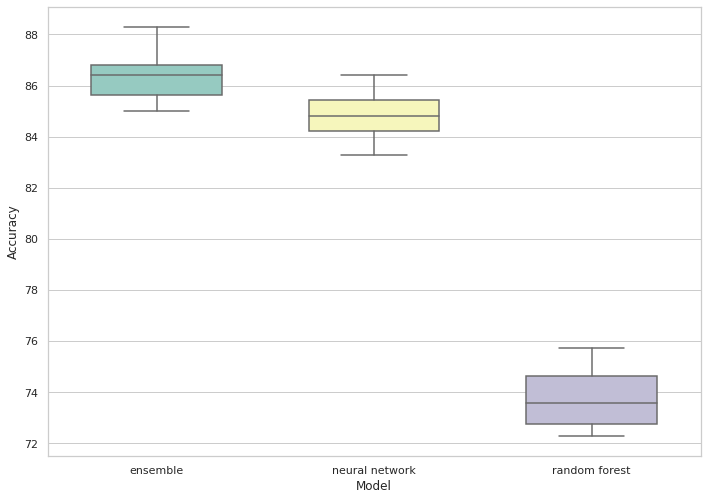

In [45]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x = "Model", y = "Accuracy", data = df, palette="Set3", width=0.6, fliersize=2)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=10)